In [ ]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact

import scipy.sparse as sparse
from scipy.sparse import linalg as spla

Populating the interactive namespace from numpy and matplotlib


## Sparse matrices

A matrix is more than a two dimensional array. It also defines a linear operator acting on vectors in $\mathbb{R}^{n}$.

We must consider
  1. the container functionality (e.g., indexing)
  2. the algebraic operations a matrix must perform (e.g., matrix vector multiplication)

In [ ]:
## In practice, you should use the functions in the scipy sparse module
?sparse

# Let us create a simple sparse matrix operator, just to see how they work (in practice use the scipy sparse module)
## Example: Create an operator for the 2nd order finite difference matrix

In [ ]:
## A class is a recipe for creating an object
## an object is a specific instance of a class

class Finite_Difference_Order2:
    def __init__(self, m, h):
        ## this method gets called once when you create an
        ## object
        self.m = int(m)
        assert self.m >= 0
        self.shape = (self.m, self.m)
        assert h > 0
        self.h = h
        self._factor = 1.

    ## a decorator modifies the behavior of a function or method
    ## in this case `classmethod` give the method the ability to
    ## instantiate a new version of the class with the input variable
    ## `cls` instead of `self`, which is an object
    @classmethod
    def _new(cls, matrix):
        """creates a new copy of the object"""
        new_matrix = cls(matrix.m, matrix.h)
        return new_matrix

    def __mul__(self, a):
        """Defines scalar multiplication self*a"""
        assert isscalar(a)
        result = self._new(self)
        result._factor *= a
        return result

    def __rmul__(self, a):
        """Defines scalar multiplication a*self"""
        return self.__mul__(a)

    def __matmul__(self, b):
        """Defines matrix vector multiplication self@b"""
        if b.ndim == 1:
            assert b.size == self.m
            result = b.copy()
            result[0] = -2*b[0] + b[1]
            for j in np.arange(1, self.m-1):
                result[j] = b[j-1] - 2*b[j] + b[j+1]
            result[-1] = -2*b[-1] + b[-2]
        result *= self._factor/self.h**2
        return result

    def __getitem__(self, key):
        """defines indexing for the object i.e., `object[index]`"""
        assert len(key) == 2
        i, j = key
        assert 0 <= i < self.m
        assert 0 <= j < self.m
        # if (i == j):
        #     output = -2.
        # elif (i-j == 1 or i-j == -1):
        #     output = 1.
        # else:
        #     output = 0.
        # return output
        # return -2 if i == j elif 1 if i-j == -1 or i-j == 1 else 0.
        return -2.*(i == j) + 1.*((i-j == 1)|(i-j == -1))

    def transpose(self):
        """This matrix is symmetric"""
        return self


A = Finite_Difference_Order2(4, 0.1)
2.*A @ ones(4)



array([-200.,    0.,    0., -200.])

# A common format for a sparse matrix
Suppose we have a `n` by `m` matrix `T`:

  1. `values` contains only the nonzero elements of the matrix, grouped by row
  2. `rows` the 'j' index for each value in `values`
  3. `offsets` used to construct the slice of `values` and `rows` for row `i`. The nonzero elements of row `i` are given by
```
slice = offset[i]:offset[i+1]
T[i, slice] = values[slice]
```
Additional info:
  - Length of `rows` is the same as the length of `values`
  - Length of `offsets` is `m + 1`
  - last element is `offsets[-1] = values.size`


In [ ]:
T = diag(-2*ones(4)) + diag(ones(3), -1) + diag(ones(3), 1)
T

array([[-2.,  1.,  0.,  0.],
       [ 1., -2.,  1.,  0.],
       [ 0.,  1., -2.,  1.],
       [ 0.,  0.,  1., -2.]])

In [ ]:
values = [-2., 1., 1., -2., 1., 1., -2., 1., 1., -2.]
rows = [0, 1, 0, 1, 2, 1, 2, 3, 2, 3]
offsets = [0, 2, 5, 8, 10]

In [ ]:
i = 3
print('The nonzero entries of row', i+1)
print(rows[offsets[i]:offsets[i+1]])
print(values[offsets[i]:offsets[i+1]])

The nonzero entries of row 4
[2, 3]
[1.0, -2.0]


In [ ]:
class Sparse_Matrix:
    def __init__(self, values, row_indices, offsets, shape):
        assert len(shape) == 2
        self.shape = shape
        self.values = np.array(values)
        assert self.values.ndim == 1
        self.nnz = self.values.size
        self.row_indices = np.array(row_indices)
        self.offsets = np.array(offsets)

    @classmethod
    def _new(cls, matrix):
        new_matrix = cls(
            matrix.values.copy(),
            matrix.row_indices.copy(),
            matrix.offsets.copy(),
            matrix.shape)
        return new_matrix

    def __mul__(self, a):
        assert isscalar(a)
        result = self._new(self)
        result.values *= a
        return result

    def __rmul__(self, a):
        return self.__mul__(a)

    def __matmul__(self, a):
        assert a.ndim == 1
        assert a.size == self.shape[1]
        n, m = self.shape
        result = a.copy()
        for i in arange(n):
            row = self.row_indices[
                self.offsets[i]:self.offsets[i+1]]
            vals = self.values[
                self.offsets[i]:self.offsets[i+1]]
            result[i] = sum(a[row]*vals)
        return result

    def __getitem__(self, key):
        assert len(key) == 2
        i, j = key
        assert 0 <= i < self.shape[0]
        assert 0 <= j < self.shape[1]
        row = self.row_indices[self.offsets[i]:self.offsets[i+1]]
        if j in row:
            ind = row[row == j][0]
            vals = self.values[self.offsets[i]:self.offsets[i+1]]
            val = vals[ind]
        else:
            val = 0.
        return val

    def transpose(self):
        """not finished"""
        return None

shape = (4, 4)
A = Sparse_Matrix(values, rows, offsets, shape)

2*A@ones(4)

array([-2.,  0.,  0., -2.])

# Example: nonlinear problem
That one equation that has all the boundary layers
$$ Du'' + u(u' - 1) = 0$$
$$u(0) = \alpha,\quad u(L) = \beta $$

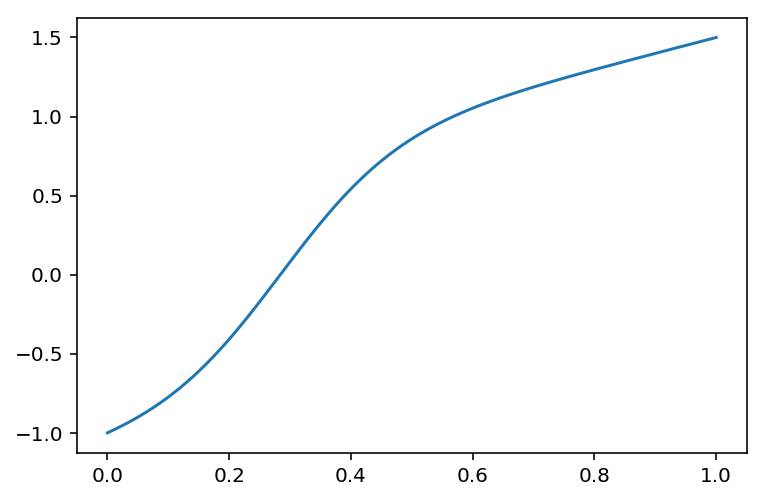

In [ ]:
m = 500
L = 1.
h = L/(m+2)

alpha = -1.
beta = 1.5
D = 0.1


## standard second order diff
e = ones(m)
L2 = D/h**2*(diag(-2.*e, 0) + diag(e[1:], 1) + diag(e[1:], -1))

## centered diff
L1 = 1/(2.*h)*(diag(e[1:], 1) - diag(e[1:], -1))



ufull = zeros((m+2, 1))
ufull[0] = alpha
ufull[-1] = beta

## Newton's method
u0 = 2*ones((m, 1))
u = u0.copy()
s = zeros((m, 1)) ## boundary terms
Ds = zeros((m, m))
Ds[0, 0] = - alpha/(2*h)
Ds[-1, -1] = beta/(2*h)

max_iter = 1000
tol = h**2

## (u_0 - 2*u_1 + u_2)/h**2
## (- 2*u_1 + u_2)/h^2   +   alpha/h**2

## u_1( (u_2 - u_0)/(2*h) - 1.)
## u_1(u_2 /(2*h) - 1.) - u_1*alpha/(2*h)

## u_m( (u_{m+1} - u_{m-1})/(2*h) - 1.)
## u_m(-u_{m-1}/(2*h) - 1.) + u_m*beta/(2*h)

## G(u) = 0
## D u'' + u(u' - 1) = 0

for n in arange(max_iter):
    s[0] = D*alpha/h**2 - alpha*u[0]/(2*h)
    s[-1] = D*beta/h**2 + beta*u[-1]/(2*h)
    ## L2@u + diag(u)@(L1@u - 1.) + s(u)
    r = L2@u + u*(L1@u - 1.) + s
    J = L2 + diag(L1@u.flatten() - 1.) + diag(u.flatten())@L1 + Ds
    y = solve(J, r)
    u = u - y
    err = absolute(r).max()
    if err < tol:
        break

if err > tol:
    print('Warning: Newton`s method did not converge')

ufull[1:-1] = u

x = linspace(0, L, m+2)
plot(x, ufull);

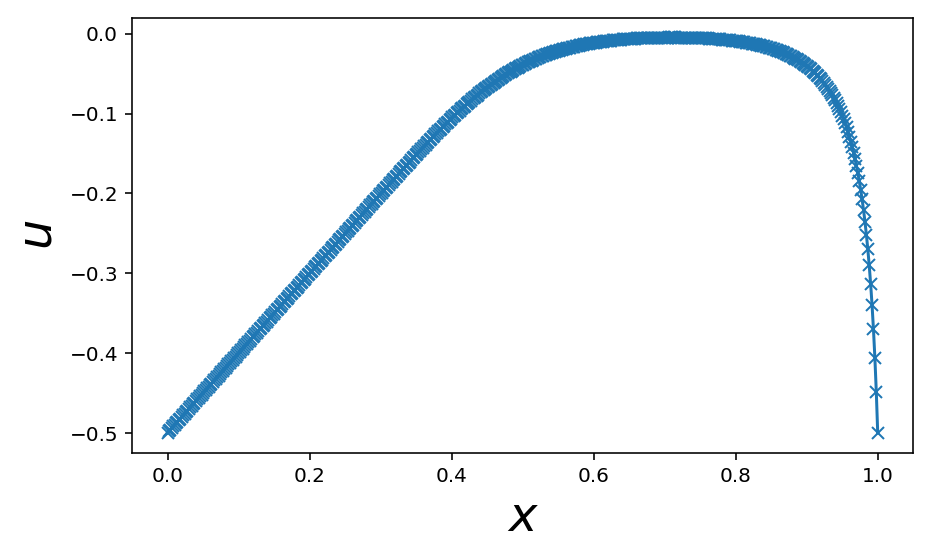

In [ ]:
m = 500
L = 1.
h = L/(m+2)


def newton_solve(u0, tol, params, max_iter=500): ## tol should be O(h^2)
    alpha, beta, D = params
    ufull = zeros((m+2, 1))
    ufull[0] = alpha
    ufull[-1] = beta
    u = u0.copy()
    e = ones(m)
    L2 = D/h**2*(diag(-2*e, 0) + diag(e[:-1], 1) + diag(e[1:], -1))
    L1 = 1/(2.*h)*(diag(e[:-1], 1) - diag(e[1:], -1))
    s = zeros((m, 1))
    dsdu = zeros((m, m))
    for n in arange(max_iter):
        s[0] = alpha/h*(D/h - 0.5*u[0])
        s[-1] = beta/h*(D/h + 0.5*u[-1])
        dsdu[0, 0] = -0.5*alpha/h
        dsdu[-1, -1] = 0.5*beta/h
        r = L2@u + u*(L1@u - 1.) + s
        uflat = u.flatten()
        J = L2 + diag(L1@uflat - 1.) + diag(uflat)@L1 + dsdu
        y = solve(J, r)
        u = u - y
        x_rel_err = absolute(y).max()/absolute(u).max()
        residual_err = absolute(r).max()
        if residual_err < tol:
            #print(n, x_rel_err, residual_err)
            ufull[1:-1] = u
            return ufull
    print('warning: max iterations reached without convergence')
    print('err_sol =', absolute(y).max())
    print('residual =', absolute(r).max())
    ufull[1:-1] = u
    return ufull






u0 = 2.*ones((m, 1))
# u0 = linspace(0, 1, m)[:, None]

D = 0.005
alpha = -0.5
beta = -.5

u = newton_solve(u0, h**2, (alpha, beta, D))
x = linspace(0, L, m+2)
figure(1, [7, 4])
plot(x, u, '-x')
xlabel(r'$x$', fontsize=24);
ylabel(r'$u$', fontsize=24);

In [ ]:
alpha = -1.
beta = 1.5
a = 0.
b = L
x = linspace(0, L, m+2)
u_outer_a = x - a + alpha
u_outer_b = x - b + beta
A = 0.5*(a - b - (alpha - beta))
C = 0.5*(alpha + beta - (a + b))
u_outer = x + C
xbar = -C


@interact(D=(0.001, 0.01, 0.001))
def plotfn(D=0.1):
    figure(1, [7, 4])
    u = newton_solve(u0, h**2, (alpha, beta, D))
    U = A*tanh(A*(x - xbar)/2./D)
    plot(x, u, '-x')
    # plot(x, u_outer_a)
    # plot(x, u_outer_b)
    plot(x, u_outer + U)
    # ylim(-0.1, 1.1);
    xlabel(r'$x$', fontsize=24);
    ylabel(r'$u$', fontsize=24);

interactive(children=(FloatSlider(value=0.01, description='D', max=0.01, min=0.001, step=0.001), Output()), _d…

# Example: mean first exit time
Let $u$ be the mean first exit time (also called the mean first passage time) for a Brownian random walker to reach the boundary of the square $[0, L]^2$ for the first time. Given the random walkers initial position $x\in (0, L)^2$, the mean first exit time $u(x)$ satisifies
$$ D\nabla^2 u = -1, \quad x \in (0, L)^2,$$
with zero Dirichlet boundaries on $\partial [0, L]^2$.

In [ ]:
L = 10. ## light years
D = 0.5 ## light years ^2 per scores of fortnights
Tscale = L**2/D ## scores of fortnights

## grid
m = 50
h = 1./(m + 2)
X, Y = meshgrid(linspace(0, 1, m+2), linspace(0, 1, m+2))
ugrid = zeros(X.shape)

## rhs

def f(x, y):
    return -ones(x.shape)

## rhs of the linear system: A@u = rhs
## shape m^2, 1
F = f(X[1:-1, 1:-1], Y[1:-1, 1:-1])
rhs = F.flatten()

## matrix m^2 x m^2
## I, T, I
##    I, T, I
##       I, T, I
I = eye(m)
e = ones(m)
T = diag(-4*e, 0) + diag(e[1:], -1) + diag(e[1:], 1)
S = diag(e[1:], -1) + diag(e[1:], 1)
A = (kron(I, T) + kron(S, I))/h**2

u = solve(A, rhs)
ugrid[1:-1, 1:-1] = u.reshape(m, m)

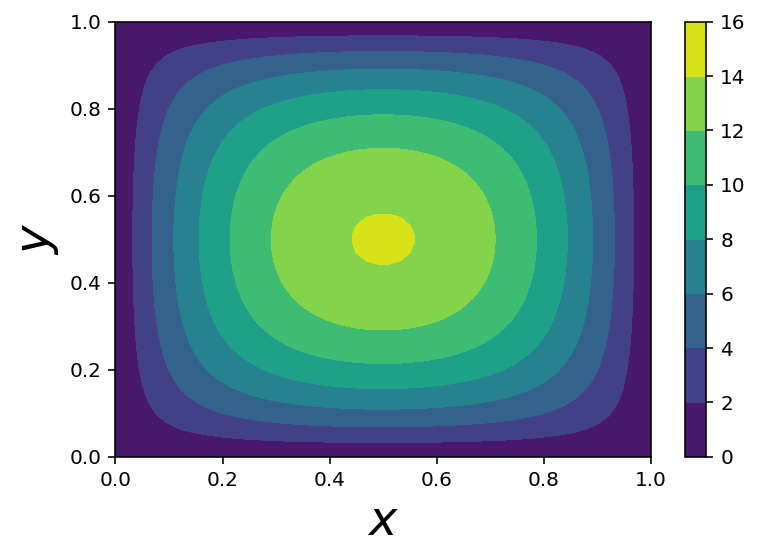

In [ ]:
contourf(X, Y, Tscale*ugrid)
colorbar();
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

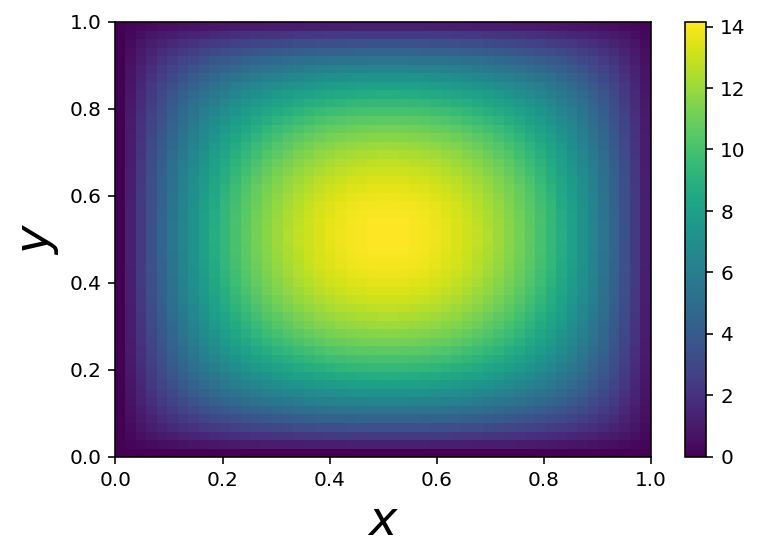

In [ ]:
pcolor(X, Y, Tscale*ugrid)
colorbar();
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

# Stochastic simulation
We can sample the random first exit time

exit time = 18.641000000000002


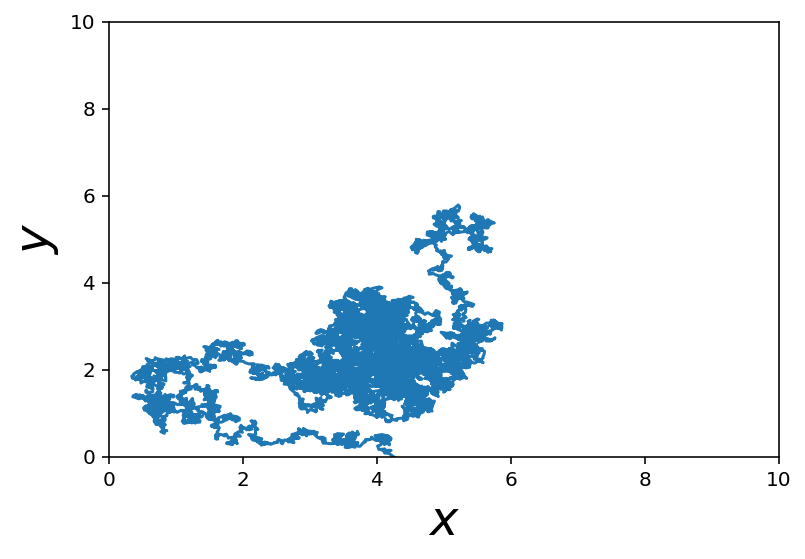

In [ ]:
X0 = array([L/2, L/2])
N = 100000
dt = 0.001
sigma = sqrt(2*D*dt)
DX = normal(0, sigma, (N, 2))
X = X0 + DX.cumsum(axis=0)
## this gives us the index of the first element of the solution that reach the boundary
exit_index = arange(N)[any((X < 0) | (X > L), axis=-1)][0]
t_exit = exit_index*dt
print('exit time =', t_exit)
plot(X[:exit_index+1, 0], X[:exit_index+1, 1])
xlim(0, L)
ylim(0, L)
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);